In [24]:
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
np.random.seed(3)

In [25]:
# Load environment
data_folder = Path("data/")
building_attributes = data_folder / 'building_attributes.json'
solar_profile = data_folder / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
#building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
building_ids = ["Building_1"]
env = CityLearn(building_attributes, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = ['ramping','1-load_factor','peak_to_valley_ratio','peak_demand','net_electricity_consumption'])
observations_spaces,actions_spaces = env.get_state_action_spaces()

In [27]:
actions_space=np.arange(-0.2,0.21,0.1)
num_actions=actions_space.shape[0]
def reward_fun(mu,temp_diff,action,soc,epsilon=0.01):
    p=np.sign(mu-temp_diff)
    a=(p+1)*action
    b=p*(np.sign(soc+p*action-epsilon-1)+1)
    if action<0:
        c=epsilon*action*p*np.sign(soc+action)
    else:
        c=epsilon*action*p
    return(a-b+c)
    


Text(0.5, 1.0, 'RBC')

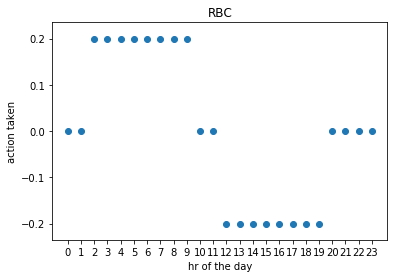

In [28]:
actions_desired=[0]*2+[0.2]*8+[0]*2+[-0.2]*8+[0]*4
plt.scatter(range(24),actions_desired)
plt.xticks(np.arange(24))
plt.xlabel('hr of the day')
plt.ylabel('action taken')
plt.title('RBC')

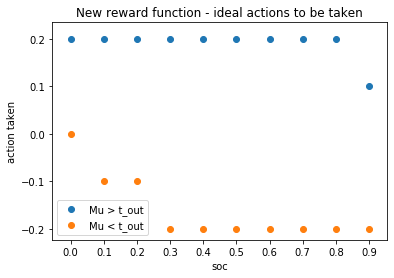

In [62]:
# test data to check if the reward fucntion is working
def reward_fun(mu,temp,action,soc,epsilon=0.01):
    p=np.sign(mu-temp)
    a=(p+1)*action
    b=p*(np.sign(soc+p*action-epsilon-1)+1)
    if action<0:
        c=epsilon*action*p*np.sign(soc+action)
    else:
        c=epsilon*action*p
    return(a-b+c)

import numpy as np
t_out=[10,14]
mu=12
soc=np.arange(0,1,0.1)
action=[-0.2,-0.1,0,0.1,0.2]

Q=np.zeros((2,10,5))
for i in range(2):
    for j in range(10):
        for k in range(5):
            Q[i,j,k]=reward_fun(mu,t_out[i],action[k],soc[j])
            
            
l1=[]
a1=[]
l2=[]
a2=[]
for i in range(10):
    a1.append(max(Q[0,i,:]))
    l1.append(action[np.argmax(Q[0,i,:])])
    a2.append(max(Q[1,i,:]))
    l2.append(action[np.argmax(Q[1,i,:])])
    
    
import matplotlib.pyplot as plt

plt.scatter(soc,l1)
plt.scatter(soc,l2)
plt.xticks(soc)
plt.xlabel('soc')
plt.ylabel('action taken')
plt.title('New reward function - ideal actions to be taken')
plt.legend(['Mu > t_out','Mu < t_out'])

In [41]:
action_space=np.arange(-0.2,0.21,0.1)
#mu is updated using median
#testing the reward fucntion in city learn 
cost, cum_reward = {}, {}
gamma=0.9
alpha=0.9
na=5
from collections import defaultdict
state_action=defaultdict()
cum_reward={}
mu=12.5


def reward_fun(mu,temp,action,soc,epsilon=0.01):
    p=np.sign(mu-temp)
    a=(p+1)*action
    b=p*(np.sign(soc+p*action-epsilon-1)+1)
    if action<0:
        c=epsilon*action*p*np.sign(soc+action)
    else:
        c=epsilon*action*p
    return(a-b+c)

#Q=np.zeros((24,10,5))
for ep in range(40):
    print(ep)
    q=[]
    states=[]
    
    sq = env.reset()
    t_out=[sq[0][3]]
    t_in=[sq[0][7]]
    soc=sq[0][-2]
    s=int(sq[0][1])
    j_=int(np.ceil(soc*10))
    if j_==10:
        j_=9
    ac=np.argmax(Q[s-1,j_-1,:])
    action=action_space[ac]
    done=False
    cum_reward[ep]=[]
    while not done:
        state_action[s]=action
        ns, reward, done, _ = env.step([[0.2]])
        reward=reward_fun(mu,t_out[-1],action,soc)
       
        cum_reward[ep].append(reward)
        
        t_out.append(ns[0][3])
        t_in.append(ns[0][7])
        soc=ns[0][-2]
        j=int(np.ceil(soc*10))
        if j==10:
            j=9
        ns_ = int(ns[0][1])
        
        epsilon=np.random.rand(1)
        
        
        if epsilon<=0.8:
            ac_=np.argmax(Q[ns_-1,j,:])
            action_dash=action_space[ac_]
            
            
        else:
            ac_=np.random.choice(na)
            action_dash=action_space[ac_]
        Q[s-1,j_,ac]=Q[s-1,j_,ac]+alpha*(reward+gamma*Q[ns_-1,j,ac_]-Q[s-1,j_,ac] ) 
        action=action_dash
        s=ns_
        ac=ac_
        mu=np.median(t_out)
        j_=j
        
    cost[ep] = env.cost()
    print(cost[ep])
  
        
    
    

0
{'ramping': 0.8599843767918223, '1-load_factor': 1.0597227384062118, 'peak_to_valley_ratio': 0.0, 'peak_demand': 1.3484185384108938, 'net_electricity_consumption': 1.172535561478237, 'total': 0.8881322430174329}
1
{'ramping': 0.8599843767918223, '1-load_factor': 1.0597227384062118, 'peak_to_valley_ratio': 0.0, 'peak_demand': 1.3484185384108938, 'net_electricity_consumption': 1.172535561478237, 'total': 0.8881322430174329}
2
{'ramping': 0.8599843767918223, '1-load_factor': 1.0597227384062118, 'peak_to_valley_ratio': 0.0, 'peak_demand': 1.3484185384108938, 'net_electricity_consumption': 1.172535561478237, 'total': 0.8881322430174329}
3
{'ramping': 0.8599843767918223, '1-load_factor': 1.0597227384062118, 'peak_to_valley_ratio': 0.0, 'peak_demand': 1.3484185384108938, 'net_electricity_consumption': 1.172535561478237, 'total': 0.8881322430174329}
4
{'ramping': 0.8599843767918223, '1-load_factor': 1.0597227384062118, 'peak_to_valley_ratio': 0.0, 'peak_demand': 1.3484185384108938, 'net_elec

{'ramping': 0.8599843767918223, '1-load_factor': 1.0597227384062118, 'peak_to_valley_ratio': 0.0, 'peak_demand': 1.3484185384108938, 'net_electricity_consumption': 1.172535561478237, 'total': 0.8881322430174329}


In [44]:
Q[0]

array([[ 0.19213626,  0.05479554,  0.23375066,  0.910816  ,  0.71050012],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.06895022,  0.16056848,  0.34735911, -1.28478321, -0.70538918]])

In [50]:
action=[-0.2,-0.1,0,0.1,0.2]
hr={}
for i in range(24):
    hr[i]={}
    for j in range(10):
        hr[i][j]=action[np.argmax(Q[i,j,:])]
        
        

Text(0.5, 1.0, 'results obtained using new reward function')

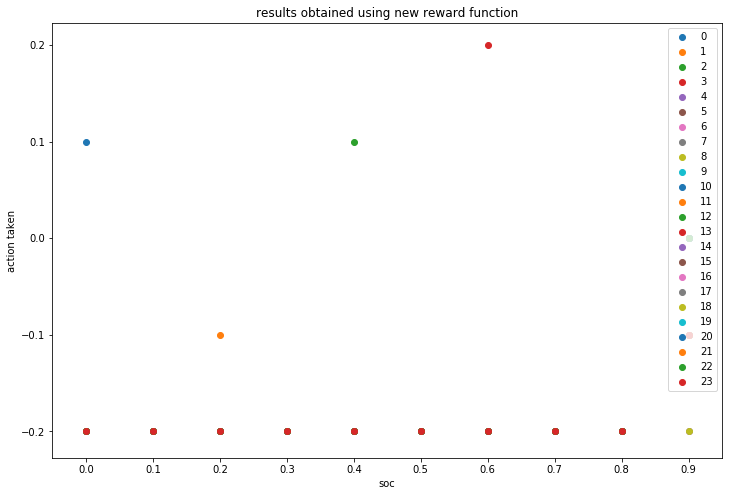

In [61]:
plt.figure(figsize=(12,8))
for i in range(24):
    plt.scatter(np.arange(0,1,0.1),list(hr[i].values()))

plt.legend(range(24),loc=1)
plt.xlabel('soc')
plt.ylabel('action taken')
plt.xticks(np.arange(0,1,0.1))
plt.title('results obtained using new reward function')